## Idea of the Project

<b>Intro</b>:
Give a theoretical introduction to the EKFs (and/or PFs), and then explore the algorithms of “filterpy” than can implement these EKFs (and/or PFs). 

<b>Data</b>:
Generate the data we are going to apply the filters to. We will use a Github repo called “deeptime”.

<b>Implementation of the filters</b>:
Application of the filters algorithms to the generated data, in the same way as showed in example 10.3.1 of the pdf of the notes of the course.

<b>1st application</b>:
the Lorenz system

<b>2nd application</b>:
the Thomas attractor

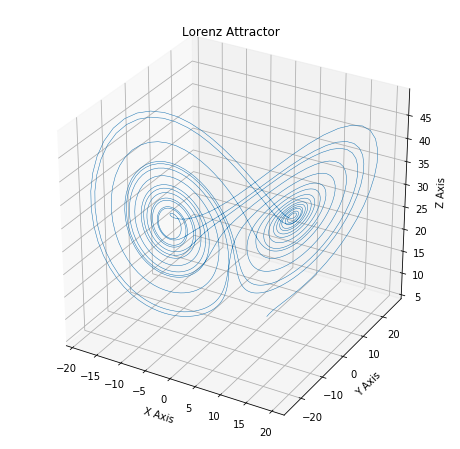

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz(xyz, *, s = 10, r = 28, b = 2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 2000

xyzs = np.empty((num_steps + 1, 3))

xyzs[0] = (5, 5, 5)

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure(figsize = (8, 8)).add_subplot(projection = '3d')

ax.plot(*xyzs.T, lw = 0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

What happens if I add a noise/perturbation to the starting point x0?

In [2]:
np.random.seed(2) # for reproducibility

In [3]:
xyzs_pert = np.empty((num_steps + 1, 3))
sigma2 = 1                                             # Variance of noise at the initial condition 
xyzs_pert[0] = (5, 5, 5) + sigma2*np.random.randn(1,3) # perturbated initial condition 

for i in range(num_steps):
    xyzs_pert[i + 1] = xyzs_pert[i] + lorenz(xyzs_pert[i]) * dt  # calcolous of Lorenz System starting by the perturbated I.C.

In [4]:
xyzs_pert[0] - xyzs[0]   

array([-0.41675785, -0.05626683, -2.1361961 ])

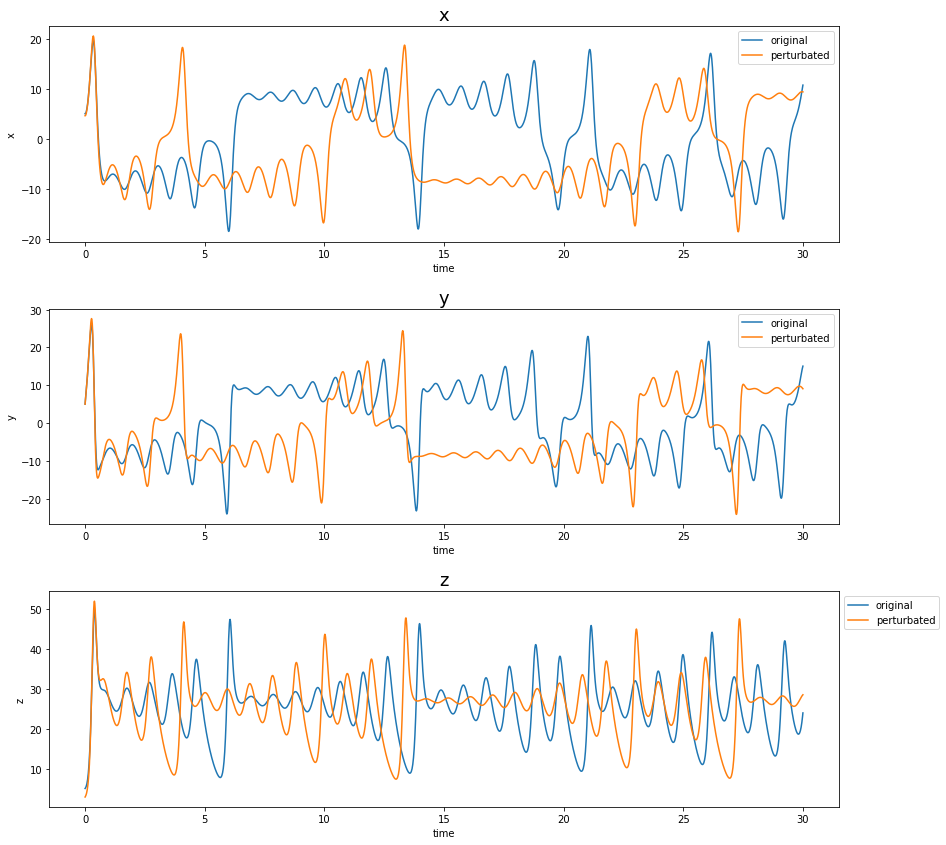

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.rcParams.update({'font.size': 15})

x = xyzs[:,0]
y = xyzs[:,1]
z = xyzs[:,2]
x_pert = xyzs_pert[:,0]
y_pert = xyzs_pert[:,1]
z_pert = xyzs_pert[:,2]

axs[0].plot(np.linspace(0, 30, len(x)), x, label = 'original');
axs[0].plot(np.linspace(0, 30, len(x_pert)), x_pert, label = 'perturbated');
axs[0].set_title('x');
axs[0].set(ylabel = 'x');
axs[0].set(xlabel = 'time');
       
axs[1].plot(np.linspace(0, 30, len(y)), y, label = 'original');
axs[1].plot(np.linspace(0, 30, len(y_pert)), y_pert, label = 'perturbated');
axs[1].set_title('y');
axs[1].set(ylabel = 'y');
axs[1].set(xlabel = 'time');

axs[2].plot(np.linspace(0, 30, len(z)), z, label = 'original');
axs[2].plot(np.linspace(0, 30, len(z_pert)), z_pert, label = 'perturbated');
axs[2].set_title('z');
axs[2].set(ylabel = 'z');
axs[2].set(xlabel = 'time');

fig.tight_layout()

axs[0].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);
axs[1].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);
axs[2].legend(bbox_to_anchor=(1.0, 1.0), prop={'size':10}, fancybox=True);

# Implementation of the Kalman Filter

We then move to generating the measurements. This is done by sampling points from the original system and adding some noise.


In [6]:
timestamp = np.linspace(0, 30, 41)

sigma3 = 2                          # noise upon the measurements we make 

x_noise = sigma3*np.random.randn(len(timestamp),1)
y_noise = sigma3*np.random.randn(len(timestamp),1)
z_noise = sigma3*np.random.randn(len(timestamp),1)

Verifica di alcuni parametri 

In [7]:
x.shape

(2001,)

In [8]:
timestamp

array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
        6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
       13.5 , 14.25, 15.  , 15.75, 16.5 , 17.25, 18.  , 18.75, 19.5 ,
       20.25, 21.  , 21.75, 22.5 , 23.25, 24.  , 24.75, 25.5 , 26.25,
       27.  , 27.75, 28.5 , 29.25, 30.  ])

In [9]:
len(timestamp)

41

In [10]:
# I extract the points of the timestamp from the non perturbated data

dt = round(len(x)/(len(timestamp)-1))

x_data = np.zeros((len(timestamp),))
y_data = np.zeros((len(timestamp),))
z_data = np.zeros((len(timestamp),))

In [11]:
for i in range(0, len(timestamp)):
    x_data[i] = x[i*dt]
    y_data[i] = y[i*dt]
    z_data[i] = z[i*dt]

In [12]:
for i in range(0, len(timestamp)):
    x_data[i] = x[i*dt]
    y_data[i] = y[i*dt]
    z_data[i] = z[i*dt]

In [13]:
# IMPORTANTE: generiamo le misure z in questo modo: z = x + noise, quindi matrice H = I

for i in range(0, len(timestamp)):
    x_data[i] = x_data[i] + x_noise[i]
    y_data[i] = y_data[i] + y_noise[i]
    z_data[i] = z_data[i] + z_noise[i]

Now we plot the measurements against the non perturbated process

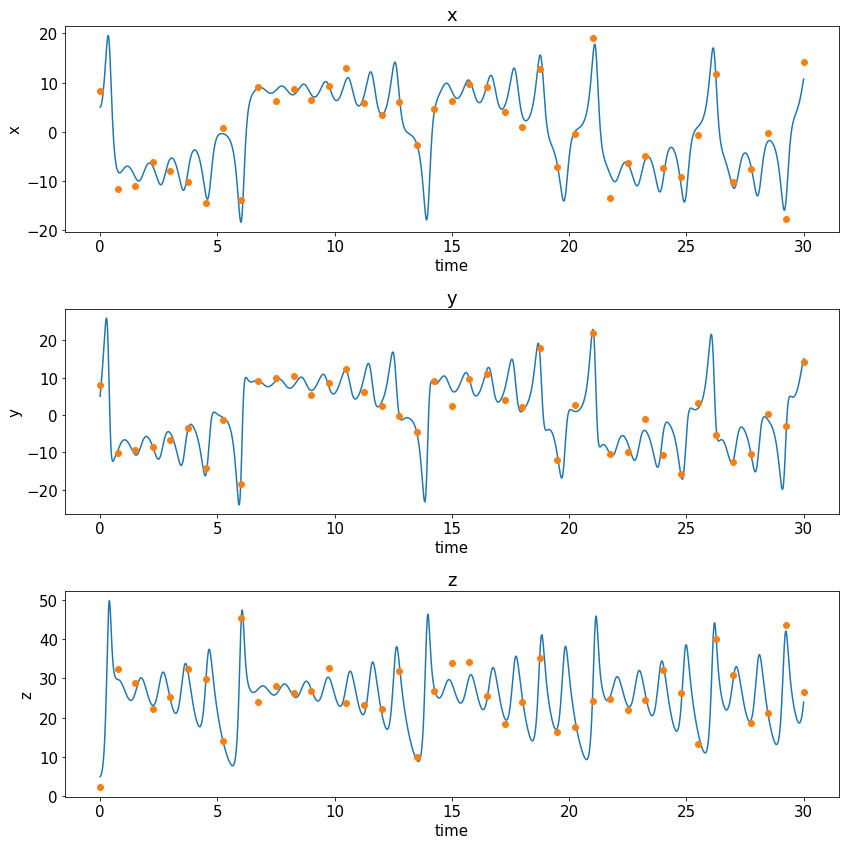

In [14]:
fig, axs = plt.subplots(3, 1, figsize = (12, 12))
plt.rcParams.update({'font.size': 15})

axs[0].plot(np.linspace(0, 30, len(x)), x);
axs[0].plot(timestamp, x_data, 'o')
axs[0].set_title('x');
axs[0].set(ylabel = 'x');
axs[0].set(xlabel = 'time');

axs[1].plot(np.linspace(0, 30, len(y)), y);
axs[1].plot(timestamp, y_data, 'o')
axs[1].set_title('y');
axs[1].set(ylabel = 'y');
axs[1].set(xlabel = 'time');

axs[2].plot(np.linspace(0, 30, len(z)), z);
axs[2].plot(timestamp, z_data, 'o')
axs[2].set_title('z');
axs[2].set(ylabel = 'z');
axs[2].set(xlabel = 'time');

fig.tight_layout()

In [15]:
sigma = 10   # riprendo i parametri di Lorenz
b = 8/3
r = 28

measurements = np.empty(shape = (3, len(timestamp)))

## re-initialize the tri-dimensional vector of measurements overwriting on it the values calculated

measurements[0,:] = x_data
measurements[1,:] = y_data
measurements[2,:] = z_data

We are now ready to implement the EKF itself. We will follow this schematic.

$$
\begin{aligned}
\text{Prior Knowledge}\\
\mathbf{H} &= \mathbf{I} \\
\\
\text{Predict Step}\\
\mathbf x_k &= \mathbf{F x}_{k-1} \\
\mathbf P_k &= \mathbf J \mathbf P_{k-1} \mathbf J^\mathsf T+\mathbf Q\\
\\
\text{Update Step}\\
\mathbf K_k &= \mathbf{P_k}(\mathbf{P_k}+\mathbf{R_k})^{-1} \\
\textbf y_k &= \mathbf z_k - \mathbf x_k \\
\mathbf x_k &=\mathbf{x_k} +\mathbf{K_k\textbf y_k} \\
\mathbf P_k &= (\mathbf{I}-\mathbf K_k)\mathbf{P_k}
\end{aligned}
$$

Note: in our case, for the way we generated the noise -> H = I

We now build all the things we need to implement the EKF.

In [16]:
def Jacobian_at(xyz, i):
    J = np.array([[-sigma       , sigma    ,  0         ],
                  [r - xyz[2, i], -1       ,  -xyz[0, i]],
                  [xyz[1, i]    , xyz[0, i],  -b        ]])
    return J

In [18]:
filtered = np.empty(shape = (3, len(timestamp)))     
forecast = np.empty(shape = (3, len(timestamp)))

filtered[:, 0] = xyzs_pert[0]

# we set F to the its initial value
F = Jacobian_at(filtered, 0)

# R is the covariance matrix for measurement noise -> we assume the noise indipendent, with variance = sigma3 = 2
R = sigma3*np.eye(3)

# P -> state covariance: we specify initial P based on our belief, then it will update itself
# come inizializzare P?  -> incertezza iniziale, quindi mi immagino una matrice identita' moltiplicata per 1/2 così da avere raggio spettrale <1 
P = 1/2*np.eye(3)

Given these parameters, we can now implement the EKF

In [19]:
# the EKF loop

inter_dt = 0.01

for i in range(1, len(timestamp)):
    
    
    F = Jacobian_at(filtered, i-1)
    
    tspan = np.linspace(0, 30/(len(timestamp)-1), round(1/inter_dt)+1) # 100 valori per 0.75 secondi (intervallo tra ogni measurement)
    local_sol = np.empty(shape = (3, len(tspan)))                      # costruisco un vettore di soluzioni locali 
    local_sol[:, 0] = filtered[:, i-1]                                 # che faccio ripartire dal risultato precedente ogni volta    
    
    for j in range (1, len(tspan)):
        local_sol[:, j] = local_sol[:, j-1] + lorenz(local_sol[:, j-1])*inter_dt  # xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
    
    forecast[:, i] = local_sol[:, len(tspan)-1] # forecast is last point of the vector
    
    # Update P

    P = F @ P @ F.T 
    
    # Update K
    
    K = P @ np.linalg.inv(P + R)
    
    print("sto stampando K")
    print(K)
    
    residual = measurements[:, i] - forecast[:, i]
    filtered[:, i] = forecast[:, i] + K @ residual
    
    P = (np.eye(3) - K) @ P
    

sto stampando K
[[ 0.81005052 -0.13720274  0.30788068]
 [-0.13720274  0.88947485  0.24902452]
 [ 0.30788068  0.24902452  0.3681182 ]]
sto stampando K
[[ 0.99333672 -0.0119005  -0.00494133]
 [-0.0119005   0.91034285 -0.03300806]
 [-0.00494133 -0.03300806  0.98058573]]
sto stampando K
[[ 9.94828231e-01 -2.32608280e-04 -1.46524934e-04]
 [-2.32608280e-04  9.91794755e-01 -3.26822367e-04]
 [-1.46524934e-04 -3.26822367e-04  9.95071007e-01]]
sto stampando K
[[ 0.99181037 -0.01062226 -0.0037397 ]
 [-0.01062226  0.96309937 -0.01660912]
 [-0.0037397  -0.01660912  0.98381981]]
sto stampando K
[[ 0.99413843 -0.00376738 -0.00174783]
 [-0.00376738  0.9818684  -0.00531132]
 [-0.00174783 -0.00531132  0.98899583]]
sto stampando K
[[ 9.93636110e-01  1.62163148e-03 -3.33410048e-03]
 [ 1.62163148e-03  9.91513919e-01  7.63908506e-04]
 [-3.33410048e-03  7.63908506e-04  9.90137404e-01]]
sto stampando K
[[ 9.94972286e-01  1.69573326e-04 -5.39633910e-05]
 [ 1.69573326e-04  9.95352092e-01  1.20718984e-06]
 [-5.3

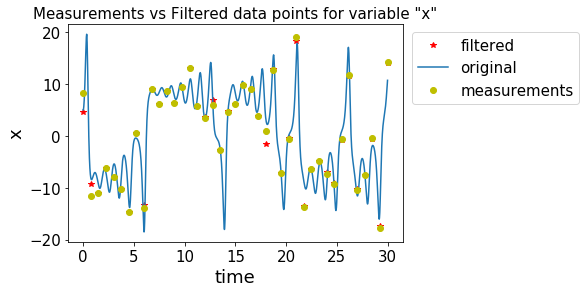

In [20]:
plt.plot(timestamp, filtered[0,:], 'r*', label = 'filtered')  # guardo solo x
plt.plot(np.linspace(0, 30, 2001), x, label = 'original')
plt.plot(timestamp, x_data, 'yo', label = 'measurements')

plt.title('Measurements vs Filtered data points for variable "x"', fontsize = 15)
plt.xlabel('time', fontsize = 18)
plt.ylabel('x', fontsize = 18)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.55, 1))

fig.tight_layout()

# Error

We now plot and compare the two errors:

- blue line: the error of the evolution of the dynamical model starting from a perturbated point
    
- orange dots: the error between the points generated by our EKF and the "real" dynamical system
    


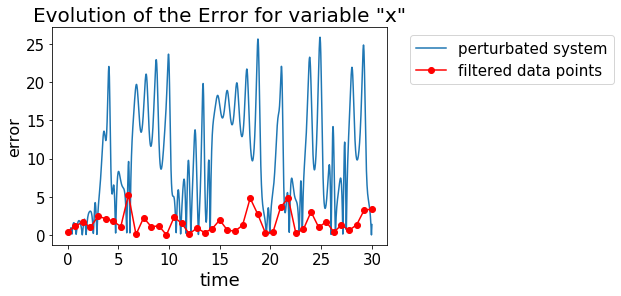

In [21]:
# error at point 1
error_pert = np.abs(x - x_pert)

# error at point 2
error_filtered = np.empty(shape = len(timestamp))

for i in range(0, len(timestamp)):
    error_filtered[i] = np.abs(x[round(len(x)/(len(timestamp)-1))*i] - filtered[0, i])


plt.plot(np.linspace(0, 30, len(x)), error_pert, label = 'perturbated system')
plt.plot(timestamp, error_filtered, '-ro', label = 'filtered data points')

plt.title('Evolution of the Error for variable "x"', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

# Particle Filter: the Ensemble Kalman Filter

Since the *filterpy* book didn't provide an exhaustive implementation of the Ensemble Kalman Filter (EnKF), we decided to rely on this paper:

https://www.osti.gov/pages/servlets/purl/1737509

The Ensemble Kalman filter (EnKF) uses a a *Monte Carlo* method to choose a large numbers of sigma points. This is done by randomly generating points distributed about the filter's initial state. This distribution is proportional to the filter's covariance $\mathbf{P}$.

By doing this, we create an ensemble of size N of the system state. Then we apply the filtering algorithm to each member of the established ensemble. The statistical properties of the forecast and analysis are thus extracted from the ensemble using the standard Monte Carlo framework. After the sigma points are passed through the filter, we find a new mean and covariance of the points and use this as the filter's new mean and covariance. 

An interpretation of EnKF is that the ensemble mean is the best estimate of the state and the spreading of the ensemble around the mean is a definition of the error in this estimate. A larger ensemble size N yields a better approximation of the state estimate and its covariance matrix. In the following, we describe the typical steps for applying the EnKF algorithm

In [22]:
from numpy.random import randn
from numpy.random import multivariate_normal

#### Initiliaze Step

Initialization is done by sampling N points from a Gaussian with given mean and covariance. 

$$
\mathbf{x} \sim \mathcal{N}(\mathbf{x}_0, \mathbf{P}_0)
$$

or, equivalently:

$$
\mathbf{x} = \mathbf{x}_0 + \mathcal{N}(0, \mathbf{P}_0)
$$


Once initialized, the EnKF works exactly as the EKF: at each iteration of the filter, we first predict our next estimate (predict step) and then update it (update step).

#### Predict Step

We first pass all of the sigma points through the state transition function and then add some noise distributed according to the  𝐐  matrix.

$$
\begin{aligned}
\mathbf{x}_{f} &= f(\mathbf{x}, \mathbf{u}) + v_Q \\
\end{aligned}
$$

#### Update Step

In the update step we compute the mean and covariance of the sigma points, compute the Kalman gain from the covariance, and then update the Kalman state by scaling the residual by the Kalman gain.

1) Compute the mean of the measurement sigmas

$$\bar{\mathbf{x}}_{f} = \frac{1}{N}\sum_1^N {x}_{f, i}$$

2) Compute the forecast error covariance matrix

$$\mathbf{P} = \frac{1}{N-1}\sum_1^N [\mathbf{x}_i - \bar{\mathbf{x}}_{f}][\mathbf{x}_i -
\bar{\mathbf{x}}_{f}]^\mathsf{T}$$

3) Create and ensemble of observations, starting from the given measurement (in other words, random Gaussian perturbations with zero mean and covariance matrix R are added to the actual measurements to create perturbed measurements)

$$\mathbf{w} = \mathbf{w}_0 + \mathcal{N}(0, \mathbf{R}_0)$$


4) Compute the Kalman gain in the "classical way"

$$\mathbf{K} = \mathbf{P}(\mathbf{P}+\mathbf{R})^{-1}$$

5) Apply the analysis step to each member of the ensemble cloud by updating the sigma points

$$\mathbf{x}_{a}  = \mathbf{x}_{f} + \mathbf{K}[\mathbf{w} -\mathbf{x}_{f}]$$

6) Compute the new filtered estimate $\mathbf{x}_{a}$

$$\bar{\mathbf{x}}_{a} = \frac{1}{N}\sum_1^N \mathbf{x}_{a, i}$$


7) Update again the P matrix
$$\mathbf{P} = \frac{1}{N-1}\sum_1^N [\mathbf{x}_i - \bar{\mathbf{x}}_{a}][\mathbf{x}_i -
\bar{\mathbf{x}}_{a}]^\mathsf{T}$$


In [23]:
# CHECK APPENDIX E FOR CODE TO IMPLEMENT THIS EnKF

In [24]:
def EnKF(filtered_points, N, measurements, P, R, Q, k):
    
    n = 3   # n is the state dimension 
    
    # compute the mean of forecast ensemble
    ub = np.mean(filtered_points, axis = 1)
    
    # compute Jacobian of observation operator at ub
    
    F = Jacobian_at(filtered, k-1)
    
    # compute Kalman gain
    
    P = F @ P @ F.T 
   
    K = P @ np.linalg.inv(P + R)
    
    print(" sto stampando K ")
    print(K)
    print(" ")
    
    wi = np.zeros([3, N])
    uai = np.zeros([3, N])
    
    for i in range(N):
        # create virtual observations
        wi[:, i] = measurements + np.random.multivariate_normal(np.zeros(3), R)
        # compute analysis ensemble
        filtered_points[:, i] = filtered_points[:, i] + K @ (wi[:,i] - filtered_points[:,i])
        
    # compute the mean of analysis ensemble
    ua = np.mean(filtered_points, axis = 1)

    # compute analysis error covariance matrix
    P = (1/(N-1)) * (filtered_points - ua.reshape(-1,1)) @ (filtered_points - ua.reshape(-1,1)).T

    return filtered_points, P


In [25]:
########################### Data Assimilation #################################

######### Change of names from the paper #####
# nt -> len(timestamp)
# solution paper:
#        ub -> forecast_mean
#        ua -> filtered_mean
#        uai -> processed_points
# B -> P
###############################

n = 3   # state dimension
m = 3   # measurement dimension
N = 200 # ensemble size

list_filtered = []
list_filtered.clear()
list_filtered_x = np.zeros(shape = (N, len(timestamp))) # I keep track of these points to plot them after --> (their evolution is shown through the orange *)

timestamp = np.linspace(0, 30, 41)

P = 1/2*np.eye(3)
Q = 0.0*np.eye(3)
R = sigma2*np.eye(3)

#time integration
forecast_mean = np.empty(shape = (3, len(timestamp)))
processed_mean = np.empty(shape = (3, len(timestamp)))
forecast_mean[:, 0] = xyzs[0]
processed_mean[:, 0] = xyzs[0]   # by the very meaning of our initialization

#initialize ensemble
processed_points = np.zeros([3, N])   # are the N points we are going to process applying to each of them the algorithm 
for i in range(N):
    processed_points[:, i] = xyzs[0] + np.random.multivariate_normal(np.zeros(n), P)  # initialize the vector of evolving point 
    list_filtered_x[i, 0] = processed_points[0, i]                                    # initialize also the list containg the record of evolution of all points

inter_dt = 0.01
tspan = np.linspace(0, 30/(len(timestamp)-1), round(1/inter_dt)+1)

for k in range(1, len(timestamp)):

# Forecast (or Predict) Step -> local solution with Forward Euler 
    
    for i in range(N): # for each point of the ensemble
        # forecast ensemble
        local_sol = np.empty(shape = (3, len(tspan)))
        local_sol[:, 0] = processed_points[:, i]
        for j in range (1, len(tspan)): # for each point of the temporal interval
            local_sol[:, j] = local_sol[:,j-1] + lorenz(local_sol[:, j-1])*inter_dt 

        processed_points[:, i] = local_sol[:, len(tspan) - 1]

    # steps are numered according to previous labels
    
    # step 1) compute the mean of forecast ensemble
    forecast_mean[:, k] = np.mean(processed_points, axis = 1)

    # step 2) compute forecast error covariance matrix
    P = (1/(N-1))*(processed_points-forecast_mean[:, k].reshape(-1,1))@(processed_points-forecast_mean[:, k].reshape(-1,1)).T
    
    # Analysis Step (steps 3) + 4) + 5) + 6) + 7)): Application of the EnKF
    processed_points, P = EnKF(processed_points, N, measurements[:, k], P, R, Q, k)
    
    for i in range(N): # for future visualization purposes, I store the whole ensemble
        list_filtered_x[i, k] = processed_points[0, i]
    
    # compute the mean of analysis ensemble
    processed_mean[:, k] = np.mean(processed_points, axis = 1)        
        

 sto stampando K 
[[ 0.84227594 -0.10728585  0.29337056]
 [-0.10728585  0.83767828  0.32089879]
 [ 0.29337056  0.32089879  0.25806138]]
 
 sto stampando K 
[[ 0.27982842  0.29942611 -0.26623016]
 [ 0.29942611  0.86050259  0.11219662]
 [-0.26623016  0.11219662  0.89898836]]
 
 sto stampando K 
[[ 0.28350795  0.19659206 -0.1897786 ]
 [ 0.19659206  0.94093977  0.05385142]
 [-0.1897786   0.05385142  0.94786188]]
 
 sto stampando K 
[[ 0.88874977  0.20298383 -0.03483812]
 [ 0.20298383  0.60943465  0.06437142]
 [-0.03483812  0.06437142  0.98745514]]
 
 sto stampando K 
[[ 0.8397509   0.07866458 -0.07728864]
 [ 0.07866458  0.95814791  0.0369316 ]
 [-0.07728864  0.0369316   0.96110561]]
 
 sto stampando K 
[[ 0.54724247 -0.04118119 -0.12080643]
 [-0.04118119  0.99267604 -0.01086508]
 [-0.12080643 -0.01086508  0.96738338]]
 
 sto stampando K 
[[ 0.91155323  0.03441736 -0.01075   ]
 [ 0.03441736  0.98482561  0.00380157]
 [-0.01075     0.00380157  0.99827315]]
 
 sto stampando K 
[[ 9.97600277e-0

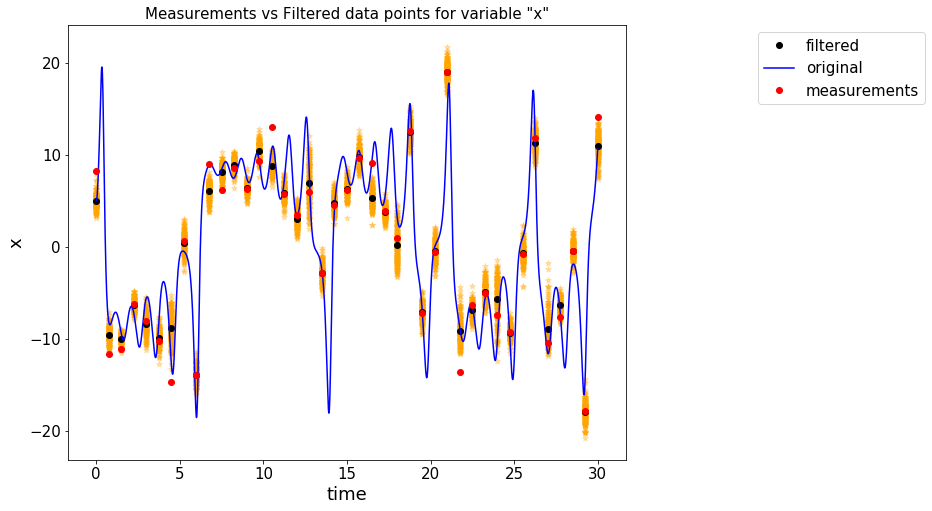

In [26]:
plt.rcParams['figure.figsize'] = [10, 8]

plt.plot(timestamp, processed_mean[0,:], 'o', label = 'filtered', c = 'black')
plt.plot(np.linspace(0, 30, 2001), x, label = 'original', c = 'blue')
plt.plot(timestamp, x_data, 'ro', label = 'measurements')

for k in range(0, len(timestamp)):
    plt.scatter(timestamp[k]*np.ones(N), list_filtered_x[:, k], alpha = 0.3, marker = '*', c = 'orange')
    
plt.title('Measurements vs Filtered data points for variable "x"', fontsize = 15)
plt.xlabel('time', fontsize = 18)
plt.ylabel('x', fontsize = 18)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.55, 1))


fig.tight_layout()

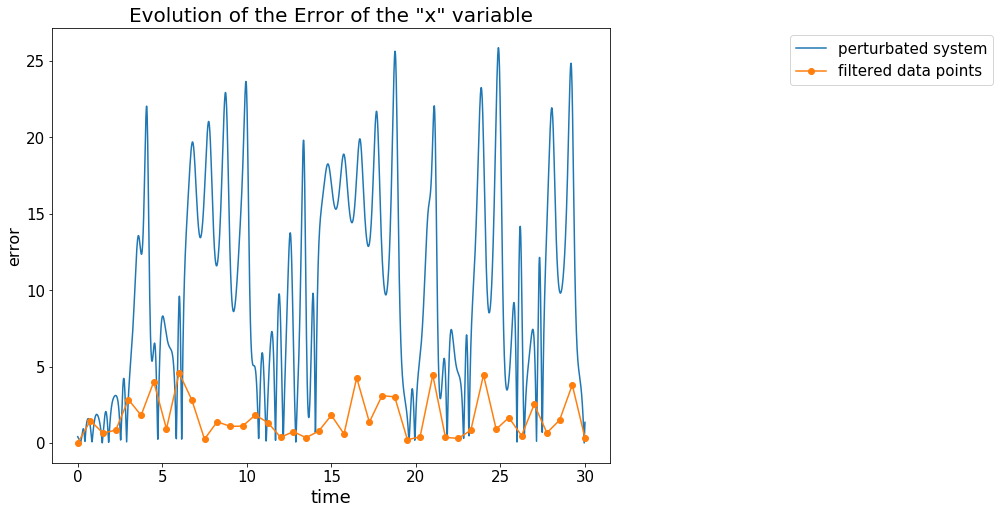

In [27]:
# error at point 1
error_pert = np.abs(x - x_pert)

# error at point 2
error_filtered_ensemble = np.empty(shape = len(timestamp))

for i in range(0, len(timestamp)):
    error_filtered_ensemble[i] = np.abs(x[round(len(x)/(len(timestamp)-1))*i] - processed_mean[0, i])


plt.plot(np.linspace(0, 30, len(x)), error_pert, label = 'perturbated system')
plt.plot(timestamp, error_filtered_ensemble, '-o', label = 'filtered data points')

plt.title('Evolution of the Error of the "x" variable', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.7, 1))

fig.tight_layout()

Comparison of the Errors

In [ ]:
plt.plot(np.linspace(0, 30, len(x)), error_pert, label = 'perturbated system')
plt.plot(timestamp, error_filtered, '-go', label = 'EKF')
plt.plot(timestamp, error_filtered_ensemble, '-ro', label = 'EnEKF')

plt.title('Evolution of the Error of the "x" variable', fontsize = 20)
plt.xlabel('time', fontsize = 18)
plt.ylabel('error', fontsize = 16)
plt.legend(loc = 'upper right', bbox_to_anchor = (1.0, 1))

fig.tight_layout()

**Analisi risultati** 

*Extended Kalman Filters* : 

E' possibile notare come con l'utilizzo dell'algoritmo degli Ekf il Kalman Gain si appiattisca quasi ad ogni iterazione su valori ~ 1, così da condizionare notevolemtne il filtering dei nostri punti a favore dei measurements piuttosto che dell' evoluzione del sistema dettata dalle equazioni di Lorenz. 
Il risultato non è quindi pienamente soddisfacente, seppur condizionato dal fatto che stiamo applicando un'approssimazione temporale del 1° ordine: invece di Ode45/RK4 stiamo utilizzando un più classico metodo di Eulero esplicito e inoltre il nostro campionamento temporale è piuttosto parziale : stiamo campionando circa ogni secondo un sistema che con i dati a nostra disposizione è soggetto a una grande variabilità temporale.
E' però soddisfacente nel complesso il grafico degli errori: va infatti notato che pur essendoci un notevole displacement a favore dei measurements, quando la differenzatra tra measured value e filtered point è tangibile, la stima filtrata è quasi sempre più vicina al sistema ideale (vedere distinguo tra punti blu e rossi). 
I nostri risultati sono stati ottenuti con le due covarianze relative agli errori di stima e misura (sigma3 e sigma2) rispettivamente uguali a 2 e 1. 

*Ensemble Kalman Filters* : 

In questo caso è ben possibile notare come l'andamento della previsione data dalla media degli N points utilizzati per questa tecnica presenti un pattern corretto e ricorrente rendendo questa tecnica complessivamente più significativa rispetto a quella dei normali Extended Kalman Filters. 
Rimane qualche errore nella stima di alcuni punti, ma, complessivamente, come visibile anche dal grafico degli errori, l'andamento è buono e, per quanto simile, leggermente migliore di quello del precedente tentativo principalmente per il significato che possiamo attribuirgli e per la maggiore affidabilità, da un punto di vista prettamente statistico. 
Il Kalman Gain è infatti spesso più significativo e non sempre esso tende ad appiattirsi (sulla diagonale ovviamente) a valori tendenti a 1.  

*Considerazioni generali estese a entrambi i metodi* :

Il risulatato complessivo è positivo : il peggior risultato in termini di errore è ccomunque significativamente minore rispetto al corrispondente valore ottenibile dal sistema perturbato, il nostro filtraggio dunque, per quanto perfezionabile, consegue in maniera soddisfacente l'esito sperato, considerando l'alta variabilità del modello originario e le tecniche utilizzate.
Un possibile sviluppo per questo progetto potrebbe essere un incremento di valori misurati attraverso un maggior campionamento temporale o l'implementazione di tecniche più complesse per l'integrazione numerica
